In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
# ---------- Helper Functions: box uncertainty set & weighting factor ----------

# 1. Construct the box-shaped uncertainty set Ξ (axis-aligned hyper-rectangle)
def build_box_uncertainty(Z_all, qmin=0.01, qmax=0.99, eta=0.02):
    """return [ell, upp] in each dimension of Z_all"""
    low  = np.quantile(Z_all, qmin, axis=0)
    high = np.quantile(Z_all, qmax, axis=0)
    span = high - low
    ell  = low  - eta * span
    upp  = high + eta * span
    # Avoid zero-width intervals
    upp = np.maximum(upp, ell + 1e-10)
    return ell, upp

def build_box_conic_from_bounds(ell, upp, n):
    """
    Rewrite the box uncertainty set  Ξ = { (x,y): ell <= (x,y) <= upp }
    into the form C1 x + c2 y <= d   (C is the nonnegative orthant cone), for direct use of Corollary 3.3.
    Return C1 (m*n), c2 (m,), d (m,), where m = 2*(n+1)
    where n = dim(x), y is a scalar
    """
    m = 2*(n+1)
    C1 = np.zeros((m, n))
    c2 = np.zeros(m)
    d  = np.zeros(m)

    row = 0
    # upper bound： x_j <= upp_j
    for j in range(n):
        C1[row, j] = 1.0
        d[row] = upp[j]
        row += 1
    # lower bound： -x_j <= -ell_j
    for j in range(n):
        C1[row, j] = -1.0
        d[row] = -ell[j]
        row += 1
    # upper bound for y： y <= upp_y
    c2[row] = 1.0
    d[row] = upp[n]
    row += 1
    # lower bound for y： -y <= -ell_y
    c2[row] = -1.0
    d[row] = -ell[n]
    row += 1

    assert row == m
    return C1, c2, d

# 2a. Compute time-dependent sample weights (exponential forgetting)
def time_weights_from_indices(time_idx, now_t, decay):
    raw = decay ** (now_t - time_idx)
    pi = raw / raw.sum()
    return pi

# 2b. Optimal weights according to Proposition 2 (for p = 1)
def optimal_weights_prop2(T, eps_over_rho):
    """
    Proposition 2 optimal weights for p = 1:
    - T = history length
    - eps_over_rho = ε/ρ in the paper, where eps in our code is ambuiguity radius, rho is the wasserstein distance between Pt and Pt+1
    Return weights w of length T
    """

    # s = floor(eps / rho)
    s = int(np.floor(eps_over_rho))
    s = max(1, min(s, T))  # truncate to [1, T]
    
    w = np.zeros(T)
    denom = s * (2 * eps_over_rho - s - 1)
    
    for t in range(T - s, T):
        # t runs from T-s to T-1  (0-index)
        w[t] = 2 * ((eps_over_rho) + (t+1) - T - 1) / denom

    return w

# 3. DRO ε-insensitive SVR
# ---------- Core：DRO-SVR following Corollary 3.3 ----------
def solve_dro_svr_cor33(X, y, C1, c2, d, pi, epsilon=1.0, rho=0.5, use_mosek=True):
    """
    Corollary 3.3 (Support Vector Regression):
      min   λ ρ + sum_i π_i s_i
      s.t.  y_i - <w,x_i> - ε + <p_i^+, d - C1 x_i - c2 y_i> <= s_i
            <w,x_i> - y_i - ε + <p_i^-, d - C1 x_i - c2 y_i> <= s_i
            || ( C1^T p_i^+ + w ,  c2^T p_i^+ - 1 ) ||_* <= λ
            || ( C1^T p_i^- - w ,  c2^T p_i^- + 1 ) ||_* <= λ
            p_i^+, p_i^- >= 0,  s_i >= 0
    """
    N, n = X.shape
    m = C1.shape[0]  # number of constraints (2*(n+1))

    w   = cp.Variable(n)
    lam = cp.Variable(nonneg=True)
    s   = cp.Variable(N, nonneg=True)

    constraints = []

    # pre-calculate (d - C1 x_i - c2 y_i) for each sample
    D_minus_Axi_cy = (d[None, :] - X @ C1.T - np.outer(y, c2))  # (N,m)

    for i in range(N):
        p_plus_i  = cp.Variable(m, nonneg=True)
        p_minus_i = cp.Variable(m, nonneg=True)

        # y_i - <w,x_i> - ε + <p_i^+, ...> <= s_i
        lhs1_i = (y[i] - X[i] @ w - epsilon + p_plus_i @ D_minus_Axi_cy[i, :])
        constraints += [lhs1_i <= s[i]]

        # <w,x_i> - y_i - ε + <p_i^-, ...> <= s_i
        lhs2_i = (X[i] @ w - y[i] - epsilon + p_minus_i @ D_minus_Axi_cy[i, :])
        constraints += [lhs2_i <= s[i]]

        # || ( C1^T p_i^+ + w ,  c2^T p_i^+ - 1 ) ||_2 <= λ
        # || ( C1^T p_i^- - w ,  c2^T p_i^- + 1 ) ||_2 <= λ
        vec_minus = cp.hstack([C1.T @ p_minus_i - w,  c2 @ p_minus_i + 1.0])
        vec_plus = cp.hstack([C1.T @ p_plus_i + w,  c2 @ p_plus_i - 1.0])

        constraints += [
            cp.norm(vec_plus,  'inf') <= lam,
            cp.norm(vec_minus, 'inf') <= lam
        ]

    # objective：λ ρ + sum_i π_i s_i
    pi_param = cp.Parameter(N, nonneg=True, value=np.asarray(pi, float))
    obj = cp.Minimize(lam * rho + pi_param @ s)

    prob = cp.Problem(obj, constraints)
    try:
        prob.solve(solver=cp.MOSEK, verbose=False)
    except cp.SolverError:
        prob.solve(solver=cp.ECOS, verbose=False)

    return w.value, prob.status

# 4. Empirical ε-insensitive SVR (no regularization, time-weighted)
def solve_empirical_svr_noreg(X, y, epsilon=1.0, sample_weights=None, use_mosek=True):
    N, n = X.shape
    w = cp.Variable(n)
    resid = y - X @ w
    loss  = cp.pos(cp.abs(resid) - epsilon)  # max(0, |r|-ε)

    if sample_weights is None:
        obj = cp.Minimize(cp.sum(loss) / N)
    else:
        sw = cp.Parameter(N, nonneg=True, value=np.asarray(sample_weights, float))
        weighted_loss = cp.sum(cp.multiply(sw, loss))
        obj = cp.Minimize(weighted_loss)

    prob = cp.Problem(obj)
    try:
        prob.solve(solver=cp.MOSEK if use_mosek else cp.ECOS, verbose=False)
    except cp.SolverError:
        prob.solve(solver=cp.ECOS, verbose=False)
    return w.value, prob.status

# 5. ε-insensitive loss
def eps_ins_loss(y_true, y_pred, eps):
    return np.maximum(0, np.abs(y_true - y_pred) - eps)

In [3]:
df = pd.read_csv("AAPL.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400
...,...,...,...,...,...,...,...
9904,2020-03-26,246.520004,258.679993,246.360001,258.440002,258.440002,63021800
9905,2020-03-27,252.750000,255.869995,247.050003,247.740005,247.740005,51054200
9906,2020-03-30,250.740005,255.520004,249.399994,254.809998,254.809998,41994100
9907,2020-03-31,255.600006,262.489990,252.000000,254.289993,254.289993,49250500


In [4]:
df['datetime'] = pd.to_datetime(df['Date'] )
df = df.set_index('datetime')
df = df.sort_index()

In [5]:
df = df['Close']
df = df.tail(500)
df

datetime
2018-04-09    170.050003
2018-04-10    173.250000
2018-04-11    172.440002
2018-04-12    174.139999
2018-04-13    174.729996
                 ...    
2020-03-26    258.440002
2020-03-27    247.740005
2020-03-30    254.809998
2020-03-31    254.289993
2020-04-01    240.910004
Name: Close, Length: 500, dtype: float64

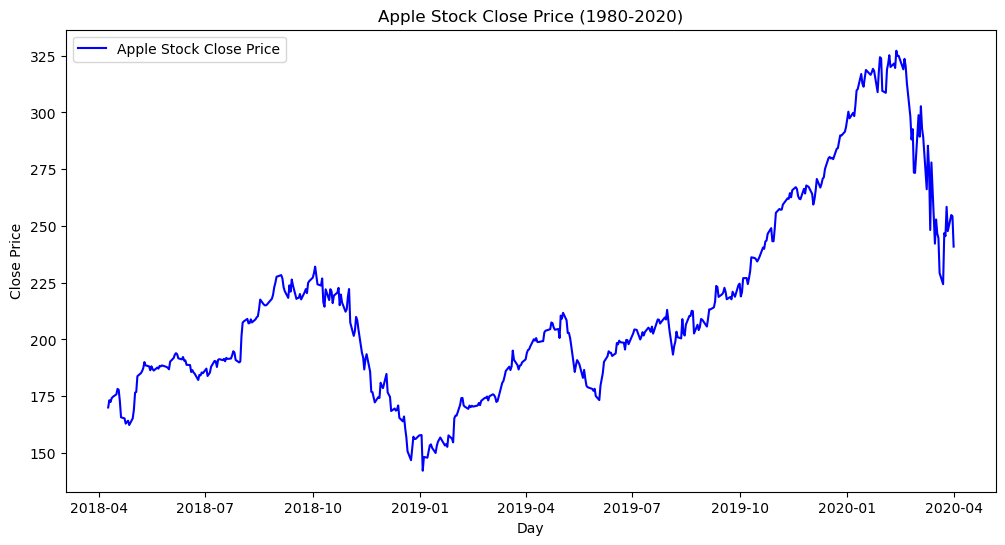

In [6]:
plt.figure(figsize=(12,6))
plt.plot(df, label="Apple Stock Close Price", color="blue")
plt.xlabel("Day")
plt.ylabel("Close Price")
plt.title("Apple Stock Close Price (1980-2020)")
plt.legend()
plt.show()

In [7]:
data = df.copy()
data = data.to_frame()
data['datetime'] = data.index
data.reset_index(drop=True, inplace=True)
data

,Close,datetime
0,170.050003,2018-04-09
1,173.250000,2018-04-10
2,172.440002,2018-04-11
3,174.139999,2018-04-12
4,174.729996,2018-04-13
...,...,...
495,258.440002,2020-03-26
496,247.740005,2020-03-27
497,254.809998,2020-03-30
498,254.289993,2020-03-31


In [8]:
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30
X_all, y_all = create_sequences(data['Close'].values, seq_length=seq_length)

T_total = len(y_all)

def rolling_forecast(X_test, y_test, w, first_idx=0):
    history = X_test[first_idx].copy()
    preds = []
    for t in range(len(y_test) - first_idx):
        y_hat = history @ w
        preds.append(y_hat)
        history = np.concatenate([history[1:], [y_hat]])
    return np.array(preds)


=== Time ratio 0.8 ===
Train+Val samples: 376
Test samples     : 94
  Train samples: 300
  Val   samples: 76
  [SAA]   val eps-loss: 0.4749936957317118
  [W-SAA] best val eps-loss: 0.6420505090297073 | best decay = 0.95
  [WDRO]  best val eps-loss: 0.42772565593593315 | best decay = 0.75 | best rho = 0.00035938136638046257
  [Prop2] best val eps-loss: 0.4063473125299509 | best rho = 10.0 | best eps/rho = 180.43999999999997
>> [SAA]   test eps-loss: 18.9442410394338
>> [W-SAA] test eps-loss: 24.126041228659155
>> [WDRO]  test eps-loss: 22.49001455056833
>> [Prop2] test eps-loss: 21.274801578551685


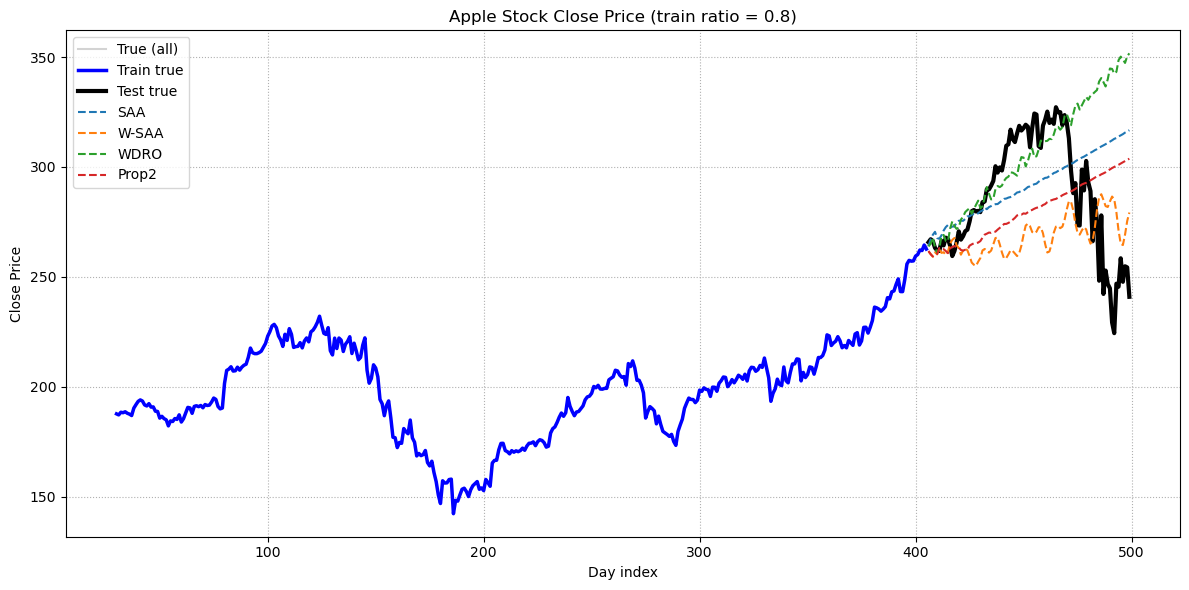


=== Time ratio 0.9 ===
Train+Val samples: 423
Test samples     : 47
  Train samples: 338
  Val   samples: 85
  [SAA]   val eps-loss: 0.2789174027680989
  [W-SAA] best val eps-loss: 0.5869108338141914 | best decay = 0.95
  [WDRO]  best val eps-loss: 0.3804627336030973 | best decay = 0.95 | best rho = 10.0
  [Prop2] best val eps-loss: 0.2365556242663906 | best rho = 10.0 | best eps/rho = 338.0
>> [SAA]   test eps-loss: 48.65776798029332
>> [W-SAA] test eps-loss: 46.17175938031506
>> [WDRO]  test eps-loss: 46.61882932741764
>> [Prop2] test eps-loss: 54.229397386230104


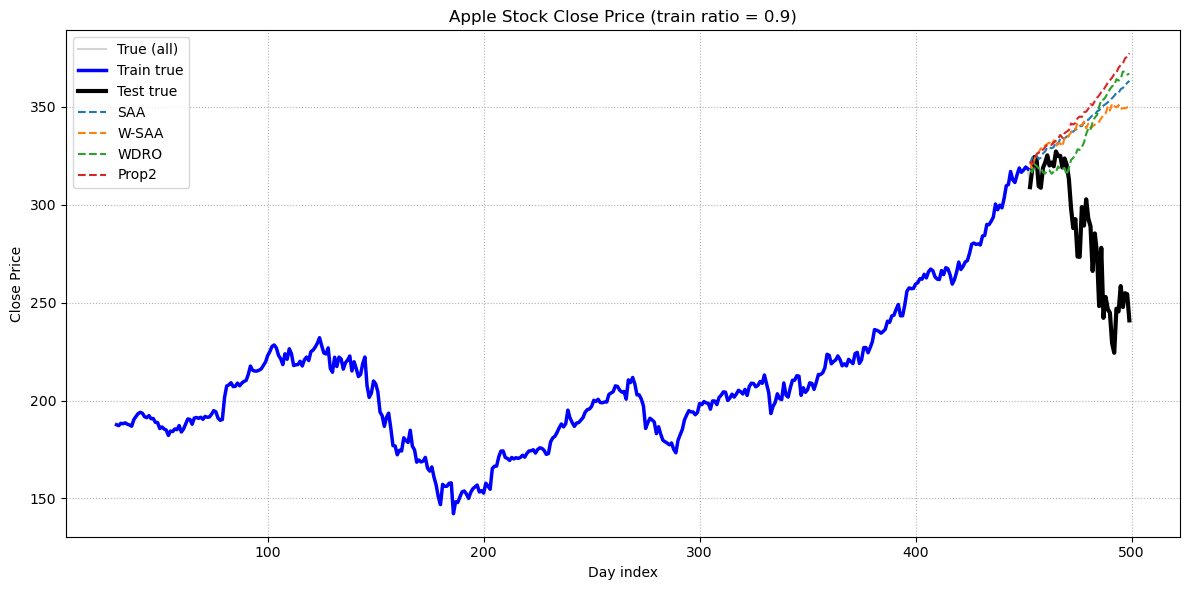

In [9]:
# ================================
# 0. Hyperparameter grid
# ================================
epsilon = 5
time_ratios = [0.8, 0.9]             # Outer split: train+val vs test
rho_list = np.logspace(-4, 1, num=10)
decay_list = [0.65, 0.75, 0.85, 0.95]

inner_ratio = 0.8               # Inner split: train vs val inside trainval

for ratio in time_ratios:
    # -------- Outer split: Train+Val / Test --------
    T_cut = int(ratio * T_total)

    X_trainval = X_all[:T_cut]
    y_trainval = y_all[:T_cut]

    X_test = X_all[T_cut:]
    y_test = y_all[T_cut:]

    print(f"\n=== Time ratio {ratio:.1f} ===")
    print("Train+Val samples:", X_trainval.shape[0])
    print("Test samples     :", X_test.shape[0])

    # -------- Inner split: Train / Validation (for grid search) --------
    T_inner = int(inner_ratio * T_cut)

    X_train = X_trainval[:T_inner]
    y_train = y_trainval[:T_inner]

    X_val = X_trainval[T_inner:]
    y_val = y_trainval[T_inner:]

    print("  Train samples:", X_train.shape[0])
    print("  Val   samples:", X_val.shape[0])

    T_time_train = len(y_train)   # Used for time-weight construction
    eps_over_rho_list = np.linspace(1.1, T_time_train, 6)

    # ================================
    # 1. Build Box uncertainty set on TRAIN only (for grid search)
    # ================================
    Z_all = np.hstack([X_all, y_all[:, None]])
    ell, upp = build_box_uncertainty(Z_all, qmin=0.01, qmax=0.99, eta=0.1)
    C1, c2, d = build_box_conic_from_bounds(ell, upp, X_all.shape[1])

    # ================================
    # 2. Baseline SAA (no hyperparameters)
    #    Only evaluated on validation
    # ================================
    w_saa_train, _ = solve_empirical_svr_noreg(
        X_train, y_train,
        epsilon=epsilon,
        sample_weights=None
    )

    y_val_pred_saa = X_val @ w_saa_train
    val_loss_saa = eps_ins_loss(y_val, y_val_pred_saa, epsilon).mean()
    print("  [SAA]   val eps-loss:", val_loss_saa)

    # ================================
    # 3. W-SAA: Tune decay using validation set
    # ================================
    best_wsaa_val_loss = np.inf
    best_decay_wsaa = None
    best_w_wsaa_train = None

    for decay in decay_list:
        time_idx = np.arange(T_time_train)

        pi_time_wsaa = time_weights_from_indices(
            time_idx,
            now_t=T_time_train - 1,
            decay=decay
        )
        pi_wsaa_samples = pi_time_wsaa / pi_time_wsaa.sum()

        w_wsaa, _ = solve_empirical_svr_noreg(
            X_train, y_train,
            epsilon=epsilon,
            sample_weights=pi_wsaa_samples
        )

        y_val_pred = X_val @ w_wsaa
        val_loss = eps_ins_loss(y_val, y_val_pred, epsilon).mean()

        if val_loss < best_wsaa_val_loss:
            best_wsaa_val_loss = val_loss
            best_decay_wsaa = decay
            best_w_wsaa_train = w_wsaa

    print("  [W-SAA] best val eps-loss:", best_wsaa_val_loss,
          "| best decay =", best_decay_wsaa)

    # ================================
    # 4. WDRO: Tune decay and rho using validation set
    # ================================
    best_wdro_val_loss = np.inf
    best_decay_wdro = None
    best_rho_wdro = None
    best_w_wdro_train = None

    for decay in decay_list:
        time_idx = np.arange(T_time_train)

        pi_time_wdro = time_weights_from_indices(
            time_idx,
            now_t=T_time_train - 1,
            decay=decay
        )
        pi_wdro_samples = pi_time_wdro / pi_time_wdro.sum()

        for rho in rho_list:
            w_wdro, _ = solve_dro_svr_cor33(
                X_train, y_train,
                C1, c2, d,
                pi_wdro_samples,
                epsilon=epsilon,
                rho=rho
            )

            y_val_pred = X_val @ w_wdro
            val_loss = eps_ins_loss(y_val, y_val_pred, epsilon).mean()

            if val_loss < best_wdro_val_loss:
                best_wdro_val_loss = val_loss
                best_decay_wdro = decay
                best_rho_wdro = rho
                best_w_wdro_train = w_wdro

    print("  [WDRO]  best val eps-loss:", best_wdro_val_loss,
          "| best decay =", best_decay_wdro,
          "| best rho =", best_rho_wdro)

    # ================================
    # 5. Prop2-DRO: Tune rho and eps_over_rho using validation set
    # ================================
    best_prop2_val_loss = np.inf
    best_rho_prop2 = None
    best_eps_over_rho_prop2 = None
    best_w_prop2_train = None

    for rho in rho_list:
        for eps_over_rho in eps_over_rho_list:
            pi_time_prop2 = optimal_weights_prop2(T_time_train, eps_over_rho)
            pi_prop2_samples = pi_time_prop2 / pi_time_prop2.sum()

            w_prop2, _ = solve_dro_svr_cor33(
                X_train, y_train,
                C1, c2, d,
                pi_prop2_samples,
                epsilon=epsilon,
                rho=rho
            )

            y_val_pred = X_val @ w_prop2
            val_loss = eps_ins_loss(y_val, y_val_pred, epsilon).mean()

            if val_loss < best_prop2_val_loss:
                best_prop2_val_loss = val_loss
                best_rho_prop2 = rho
                best_eps_over_rho_prop2 = eps_over_rho
                best_w_prop2_train = w_prop2

    print("  [Prop2] best val eps-loss:", best_prop2_val_loss,
          "| best rho =", best_rho_prop2,
          "| best eps/rho =", best_eps_over_rho_prop2)

    # =========================================================
    # 6. Final retraining on Train+Val and evaluation on Test
    # =========================================================

    # Rebuild Box uncertainty set on Train+Val
    Z_trainval = np.hstack([X_trainval, y_trainval[:, None]])
    ell_tv, upp_tv = build_box_uncertainty(Z_trainval, qmin=0.01, qmax=0.99, eta=0.1)
    C1_tv, c2_tv, d_tv = build_box_conic_from_bounds(ell_tv, upp_tv, X_trainval.shape[1])

    T_time_trainval = len(y_trainval)

    # ---- Final SAA model ----
    w_saa_full, _ = solve_empirical_svr_noreg(
        X_trainval, y_trainval,
        epsilon=epsilon,
        sample_weights=None
    )
    y_pred_saa_test = rolling_forecast(X_test, y_test, w_saa_full, 0)
    test_loss_saa = eps_ins_loss(y_test, y_pred_saa_test, epsilon).mean()
    print(">> [SAA]   test eps-loss:", test_loss_saa)

    # ---- Final W-SAA model ----
    time_idx_full = np.arange(T_time_trainval)

    pi_time_wsaa_full = time_weights_from_indices(
        time_idx_full,
        now_t=T_time_trainval - 1,
        decay=best_decay_wsaa
    )
    pi_wsaa_full = pi_time_wsaa_full / pi_time_wsaa_full.sum()

    w_wsaa_full, _ = solve_empirical_svr_noreg(
        X_trainval, y_trainval,
        epsilon=epsilon,
        sample_weights=pi_wsaa_full
    )
    y_pred_wsaa_test = rolling_forecast(X_test, y_test, w_wsaa_full, 0)
    test_loss_wsaa = eps_ins_loss(y_test, y_pred_wsaa_test, epsilon).mean()
    print(">> [W-SAA] test eps-loss:", test_loss_wsaa)

    # ---- Final WDRO model ----
    pi_time_wdro_full = time_weights_from_indices(
        time_idx_full,
        now_t=T_time_trainval - 1,
        decay=best_decay_wdro
    )
    pi_wdro_full = pi_time_wdro_full / pi_time_wdro_full.sum()

    w_wdro_full, _ = solve_dro_svr_cor33(
        X_trainval, y_trainval,
        C1_tv, c2_tv, d_tv,
        pi_wdro_full,
        epsilon=epsilon,
        rho=best_rho_wdro
    )
    y_pred_wdro_test = rolling_forecast(X_test, y_test, w_wdro_full, 0)
    test_loss_wdro = eps_ins_loss(y_test, y_pred_wdro_test, epsilon).mean()
    print(">> [WDRO]  test eps-loss:", test_loss_wdro)

    # ---- Final Prop2 model ----
    pi_time_prop2_full = optimal_weights_prop2(
        T_time_trainval,
        best_eps_over_rho_prop2
    )
    pi_prop2_full = pi_time_prop2_full / pi_time_prop2_full.sum()

    w_prop2_full, _ = solve_dro_svr_cor33(
        X_trainval, y_trainval,
        C1_tv, c2_tv, d_tv,
        pi_prop2_full,
        epsilon=epsilon,
        rho=best_rho_prop2
    )
    y_pred_prop2_test = rolling_forecast(X_test, y_test, w_prop2_full, 0)
    test_loss_prop2 = eps_ins_loss(y_test, y_pred_prop2_test, epsilon).mean()
    print(">> [Prop2] test eps-loss:", test_loss_prop2)

    # ================================
    # Plot predictions for this ratio
    # ================================

    offset = seq_length

    months = np.arange(offset, offset + len(y_all))

    plt.figure(figsize=(12, 6))

    # 1) All true values (background)
    plt.plot(months, y_all, color="lightgray", linewidth=1.5, label="True (all)")

    # 2) Train true values
    plt.plot(
        months[:T_cut],
        y_all[:T_cut],
        color="blue",
        linewidth=2.5,
        label="Train true"
    )

    # 3) Test true values
    plt.plot(
        months[T_cut:],
        y_test,
        color="black",
        linewidth=3,
        label="Test true"
    )

    # 4) Predictions on test
    plt.plot(months[T_cut:], y_pred_saa_test,  "--", label="SAA")
    plt.plot(months[T_cut:], y_pred_wsaa_test, "--", label="W-SAA")
    plt.plot(months[T_cut:], y_pred_wdro_test, "--", label="WDRO")
    plt.plot(months[T_cut:], y_pred_prop2_test,"--", label="Prop2")

    plt.xlabel("Day index")
    plt.ylabel("Close Price")
    plt.title(f"Apple Stock Close Price (train ratio = {ratio:.1f})")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()